In [1]:
import os
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
from tensorflow.keras.losses import KLDivergence, BinaryCrossentropy
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Flatten, MaxPooling2D, Conv2D, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import scipy
from PIL import Image
import warnings
warnings.catch_warnings
import cv2 as cv
from scipy import stats
from tqdm import tqdm
import shutil
import time

2025-01-16 08:39:17.661109: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 08:39:17.777350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-16 08:39:17.777397: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-16 08:39:17.778144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 08:39:17.823983: I tensorflow/core/platform/cpu_feature_g

# Load Dataset (Melanoma)

In [2]:
# # Importing required libraries
# import kagglehub

# # Downloading the dataset
# path = kagglehub.dataset_download("drscarlat/melanoma")
# print("Path to dataset files:", path)

# # Moving dataset to the current directory
# destination_dir = '.'  # Current directory

# for item in os.listdir(path):
#     source_path = os.path.join(path, item)
#     destination_path = os.path.join(destination_dir, item)

#     if os.path.isfile(source_path):
#         shutil.move(source_path, destination_path)
#     elif os.path.isdir(source_path):
#         shutil.move(source_path, destination_path)

# print("Dataset files moved to the current directory.")

# Dataset

In [3]:
# Basic config
BATCH_SIZE = 32
IMG_SIZE = 224

In [4]:
train_path = '/workspace/dermmel/DermMel/train_sep'
val_path = '/workspace/dermmel/DermMel/valid'
test_path = '/workspace/dermmel/DermMel/test'

In [9]:
classes = ['Melanoma', 'NotMelanoma']
classes

['Melanoma', 'NotMelanoma']

# Default (No Hair Removal)

In [10]:
# ImageDataGenerators
# Augmentation
train_datagen_aug_1 = ImageDataGenerator(
    rotation_range = 35,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    )

train_datagen_aug_2 = ImageDataGenerator(
    rotation_range = 30,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    )

# No augmentation
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Generators
train_generator_aug_1 = train_datagen_aug_1.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb'
)

train_generator_aug_2 = train_datagen_aug_2.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb'
)

validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb',
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = False
)

Found 10682 images belonging to 2 classes.
Found 10682 images belonging to 2 classes.
Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [11]:
class CustomF1Score(F1Score):
    def __init__(self, name="f1_score", dtype=None):
        super(F1Score, self).__init__(name=name, dtype=dtype)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to binary based on a 0.5 threshold
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        # Calculate true positives, false positives, and false negatives
        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum(y_pred * (1 - y_true))
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

        # Update the state variables
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [12]:
def evaluate_model(model, test_generator, classes, threshold=0.5):
    # Predict labels for the test data
    y_pred = model.predict(test_generator)
    # Binarize predictions based on threshold
    y_pred = (y_pred > threshold).astype(int)
    # Get true labels from the test generator
    y_true = test_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Display classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

In [13]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss over epochs.

    Parameters:
    - history: The history object returned by the model's fit method.
    """
    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
import pandas as pd

def save_training_history(history, filename):
    """Saves training history to a CSV file with the model name.

    Args:
        history: The training history object returned by model.fit().
        filename: The name of the CSV file to save the history to.
        model_name: The name of the model (string) to include in the CSV file.
    """
    results_df = pd.DataFrame(history.history)
    results_df.insert(0, 'epoch', range(1, len(results_df) + 1))  # Menambahkan kolom 'epoch'
    results_df.to_csv(filename, index=False)

## Tanpa Augmentasi

In [15]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

2025-01-16 08:41:11.904637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [16]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)

In [17]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

12683000/12683000 [==============================] - 1s 0us/step


In [18]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              984064    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [19]:
mcp = ModelCheckpoint('model_no_aug.h5', save_best_only = True)

In [20]:
start_time = time.time()

history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose = 1,
    callbacks = [lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / 10

Epoch 1/10


2025-01-16 08:41:20.521242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-01-16 08:41:20.521276: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-16 08:41:20.631410: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-16 08:41:21.768802: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x785684e6f9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-16 08:41:21.768820: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-01-16 08:41:21.772580: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-16 08:41:21.825593: I ./tensorflow/compiler/jit/device_comp

333/333 [==============================] - ETA: 0s - loss: 1.7496 - accuracy: 0.9141 - precision: 0.8876 - recall: 0.9484 - f1_score: 0.9170

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 128s 344ms/step - loss: 1.7496 - accuracy: 0.9141 - precision: 0.8876 - recall: 0.9484 - f1_score: 0.9170 - val_loss: 1.6920 - val_accuracy: 0.9139 - val_precision: 0.8533 - val_recall: 0.9994 - val_f1_score: 0.9206 - lr: 1.0000e-04
Epoch 2/10
333/333 [==============================] - 112s 338ms/step - loss: 1.3852 - accuracy: 0.9527 - precision: 0.9304 - recall: 0.9786 - f1_score: 0.9539 - val_loss: 1.6067 - val_accuracy: 0.8438 - val_precision: 0.7620 - val_recall: 1.0000 - val_f1_score: 0.8649 - lr: 1.0000e-04
Epoch 3/10
333/333 [==============================] - 112s 337ms/step - loss: 1.0986 - accuracy: 0.9738 - precision: 0.9651 - recall: 0.9831 - f1_score: 0.9740 - val_loss: 2.4845 - val_accuracy: 0.6892 - val_precision: 0.6169 - val_recall: 1.0000 - val_f1_score: 0.7631 - lr: 1.0000e-04
Epoch 4/10
333/333 [==============================] - 103s 309ms/step - loss: 0.8601 - accuracy: 0.9872 - precision: 0.9850 - recall: 0.9895 - f1_scor

In [21]:
start_inf_time = time.time()

test_result = model.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result

end_inf_time = time.time()

inference_time = end_inf_time - start_inf_time

test_result["training_time"] = total_training_time
test_result["avg_training_time"] = average_time_per_epoch
test_result["inference_time"] = inference_time

112/112 [==============================] - 28s 251ms/step - loss: 0.5392 - accuracy: 0.9539 - precision: 0.9239 - recall: 0.9893 - f1_score: 0.9555


112/112 [==============================] - 18s 157ms/step
Confusion Matrix:
[[1636  145]
 [  19 1761]]


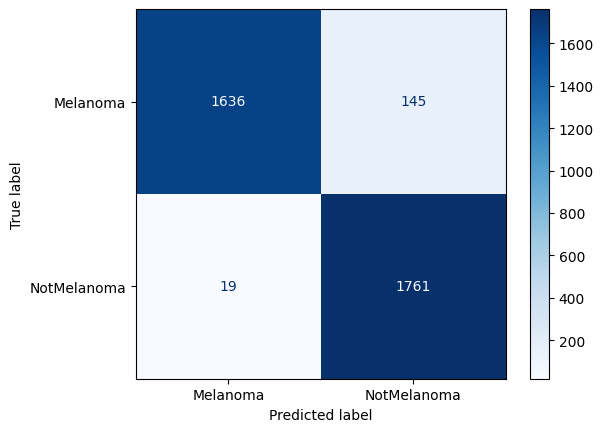

Classification Report:
              precision    recall  f1-score   support

    Melanoma     0.9885    0.9186    0.9523      1781
 NotMelanoma     0.9239    0.9893    0.9555      1780

    accuracy                         0.9539      3561
   macro avg     0.9562    0.9540    0.9539      3561
weighted avg     0.9562    0.9539    0.9539      3561



In [22]:
evaluate_model(model, test_generator, classes)

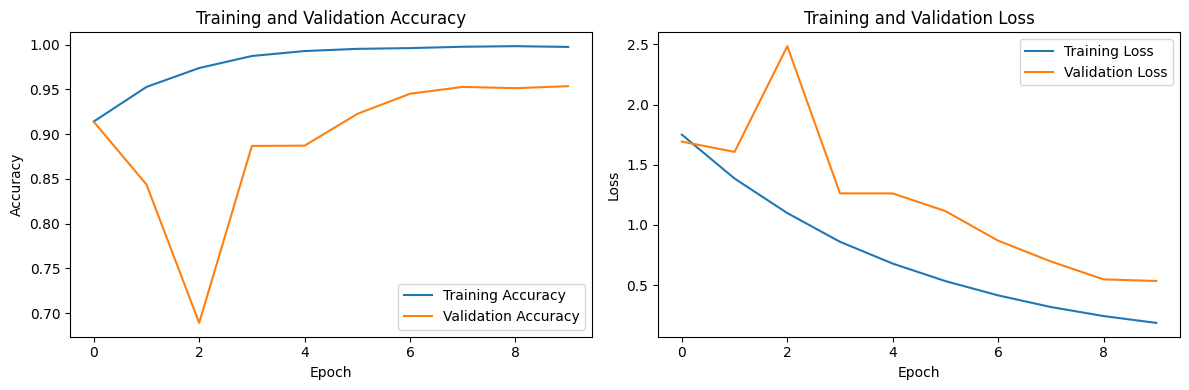

In [23]:
plot_training_history(history)

## Augmentasi 1

In [24]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

In [25]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)

In [26]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model_aug1 = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [27]:
model_aug1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model_aug1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1024)              984064    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)              

In [28]:
mcp = ModelCheckpoint('aug_1.h5', save_best_only = True)

In [29]:
start_time = time.time()

history_aug1 = model_aug1.fit(
    train_generator_aug_1,
    epochs = 10,
    validation_data = validation_generator,
    steps_per_epoch = train_generator_aug_1.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose = 1,
    callbacks = [lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / 10 

Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 1.7353 - accuracy: 0.9192 - precision: 0.8979 - recall: 0.9461 - f1_score: 0.9213

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 153s 433ms/step - loss: 1.7353 - accuracy: 0.9192 - precision: 0.8979 - recall: 0.9461 - f1_score: 0.9213 - val_loss: 2.1744 - val_accuracy: 0.6346 - val_precision: 0.5779 - val_recall: 1.0000 - val_f1_score: 0.7325 - lr: 1.0000e-04
Epoch 2/10
333/333 [==============================] - 139s 419ms/step - loss: 1.3815 - accuracy: 0.9501 - precision: 0.9235 - recall: 0.9816 - f1_score: 0.9516 - val_loss: 1.5485 - val_accuracy: 0.8542 - val_precision: 0.7743 - val_recall: 1.0000 - val_f1_score: 0.8728 - lr: 1.0000e-04
Epoch 3/10
333/333 [==============================] - 136s 408ms/step - loss: 1.1200 - accuracy: 0.9564 - precision: 0.9386 - recall: 0.9767 - f1_score: 0.9573 - val_loss: 1.1063 - val_accuracy: 0.9395 - val_precision: 0.8933 - val_recall: 0.9983 - val_f1_score: 0.9429 - lr: 1.0000e-04
Epoch 4/10
333/333 [==============================] - 137s 412ms/step - loss: 0.9030 - accuracy: 0.9609 - precision: 0.9477 - recall: 0.9758 - f1_scor

In [30]:
start_inf_time = time.time()

test_result_model_aug1 = model_aug1.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result_model_aug1

end_inf_time = time.time()

inference_time = end_inf_time - start_inf_time

test_result_model_aug1["training_time"] = total_training_time
test_result_model_aug1["avg_training_time"] = average_time_per_epoch
test_result_model_aug1["inference_time"] = inference_time

112/112 [==============================] - 28s 248ms/step - loss: 0.3331 - accuracy: 0.9551 - precision: 0.9407 - recall: 0.9713 - f1_score: 0.9558


112/112 [==============================] - 16s 141ms/step
Confusion Matrix:
[[1672  109]
 [  51 1729]]


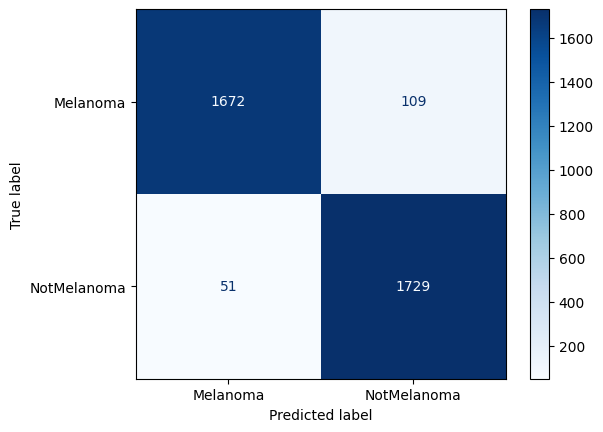

Classification Report:
              precision    recall  f1-score   support

    Melanoma     0.9704    0.9388    0.9543      1781
 NotMelanoma     0.9407    0.9713    0.9558      1780

    accuracy                         0.9551      3561
   macro avg     0.9555    0.9551    0.9551      3561
weighted avg     0.9556    0.9551    0.9551      3561



In [31]:
evaluate_model(model_aug1, test_generator, classes)

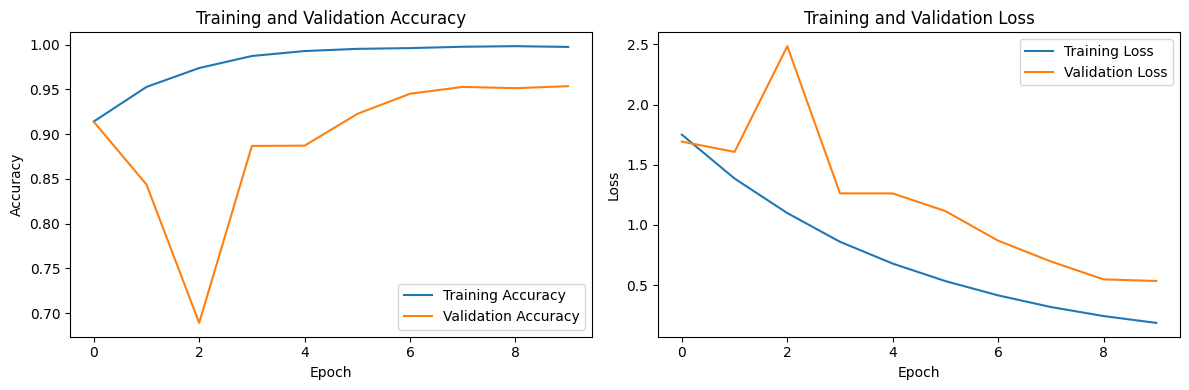

In [32]:
plot_training_history(history)

## Augmentasi 2

In [33]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

In [34]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)

In [35]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model_aug2 = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [36]:
model_aug2.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model_aug2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1024)              984064    
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)              

In [37]:
mcp = ModelCheckpoint('aug_2.h5', save_best_only = True)

In [38]:
start_time = time.time()

history_aug2 = model_aug2.fit(
    train_generator_aug_2,
    epochs = 10,
    validation_data = validation_generator,
    steps_per_epoch = train_generator_aug_2.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose = 1,
    callbacks = [lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / 10 

Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 1.7419 - accuracy: 0.9207 - precision: 0.8968 - recall: 0.9506 - f1_score: 0.9229

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 152s 427ms/step - loss: 1.7419 - accuracy: 0.9207 - precision: 0.8968 - recall: 0.9506 - f1_score: 0.9229 - val_loss: 2.1597 - val_accuracy: 0.6289 - val_precision: 0.5740 - val_recall: 1.0000 - val_f1_score: 0.7294 - lr: 1.0000e-04
Epoch 2/10
333/333 [==============================] - 136s 410ms/step - loss: 1.4053 - accuracy: 0.9474 - precision: 0.9227 - recall: 0.9767 - f1_score: 0.9489 - val_loss: 1.5027 - val_accuracy: 0.8556 - val_precision: 0.7760 - val_recall: 0.9994 - val_f1_score: 0.8737 - lr: 1.0000e-04
Epoch 3/10
333/333 [==============================] - 130s 390ms/step - loss: 1.1479 - accuracy: 0.9569 - precision: 0.9385 - recall: 0.9778 - f1_score: 0.9578 - val_loss: 1.3169 - val_accuracy: 0.8733 - val_precision: 0.7981 - val_recall: 0.9994 - val_f1_score: 0.8875 - lr: 1.0000e-04
Epoch 4/10
333/333 [==============================] - 129s 388ms/step - loss: 0.9292 - accuracy: 0.9625 - precision: 0.9470 - recall: 0.9799 - f1_scor

In [39]:
start_inf_time = time.time()

test_result_model_aug2 = model_aug2.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result_model_aug2

end_inf_time = time.time()

inference_time = end_inf_time - start_inf_time

test_result_model_aug2["training_time"] = total_training_time
test_result_model_aug2["avg_training_time"] = average_time_per_epoch
test_result_model_aug2["inference_time"] = inference_time

112/112 [==============================] - 27s 238ms/step - loss: 0.3069 - accuracy: 0.9559 - precision: 0.9603 - recall: 0.9511 - f1_score: 0.9557


112/112 [==============================] - 16s 138ms/step
Confusion Matrix:
[[1711   70]
 [  87 1693]]


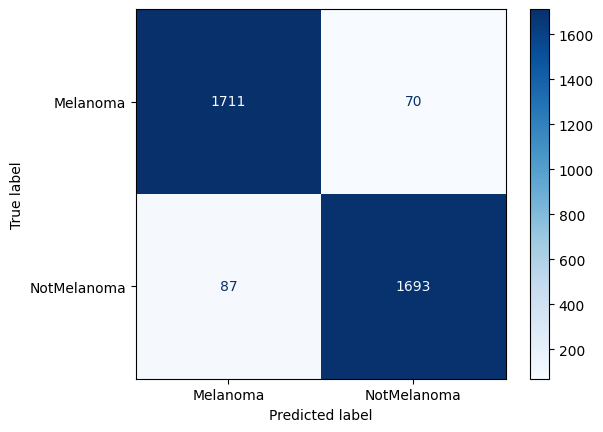

Classification Report:
              precision    recall  f1-score   support

    Melanoma     0.9516    0.9607    0.9561      1781
 NotMelanoma     0.9603    0.9511    0.9557      1780

    accuracy                         0.9559      3561
   macro avg     0.9560    0.9559    0.9559      3561
weighted avg     0.9560    0.9559    0.9559      3561



In [40]:
evaluate_model(model_aug2, test_generator, classes)

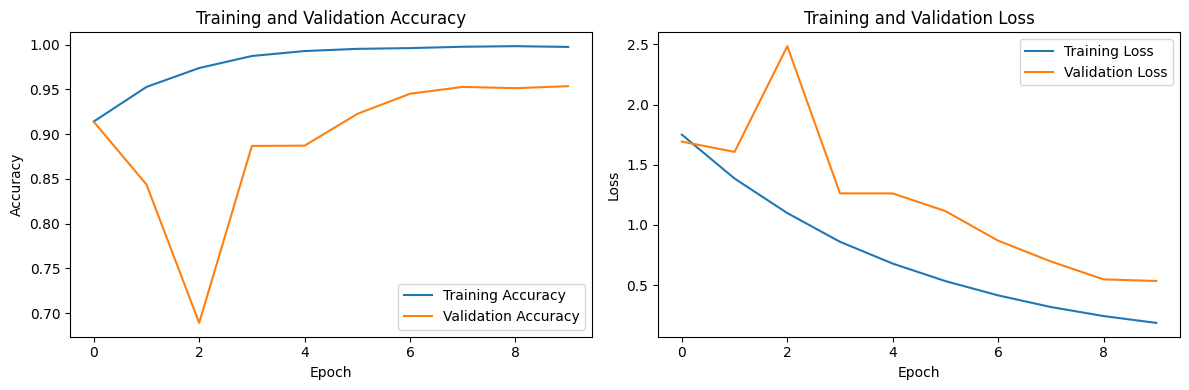

In [41]:
plot_training_history(history)

# Results

In [42]:
import pandas as pd

def save_test_aug_results_to_csv(results_dict, filename):
    """
    Saves the results of model testing to a CSV file.
    Args:
        results_dict (dict): 
            Dictionary dengan key = nama model (string) 
            dan value = dictionary metrik evaluasi (loss, acc, dsb).
        filename (str): 
            Nama file CSV.
    """
    df = pd.DataFrame.from_dict(results_dict, orient='index')
    df.index.name = "Skenario"
    df.reset_index(inplace=True)
    df.to_csv(filename, index=False)

test_results = {
    "model_no_aug": test_result,
    "model_aug_1": test_result_model_aug1,
    "model_aug_2": test_result_model_aug2,
}

save_test_aug_results_to_csv(test_results, "model_test_aug_results.csv")
pd.read_csv('model_test_aug_results.csv')

,Skenario,loss,accuracy,precision,recall,f1_score,training_time,avg_training_time,inference_time
0,model_no_aug,0.539167,0.953946,0.923924,0.989326,0.955507,979.540885,97.954088,28.140174
1,model_aug_1,0.333147,0.955069,0.940696,0.971348,0.955777,1410.154842,141.015484,27.827340
2,model_aug_2,0.306855,0.955911,0.960295,0.951124,0.955687,1345.280168,134.528017,26.732440


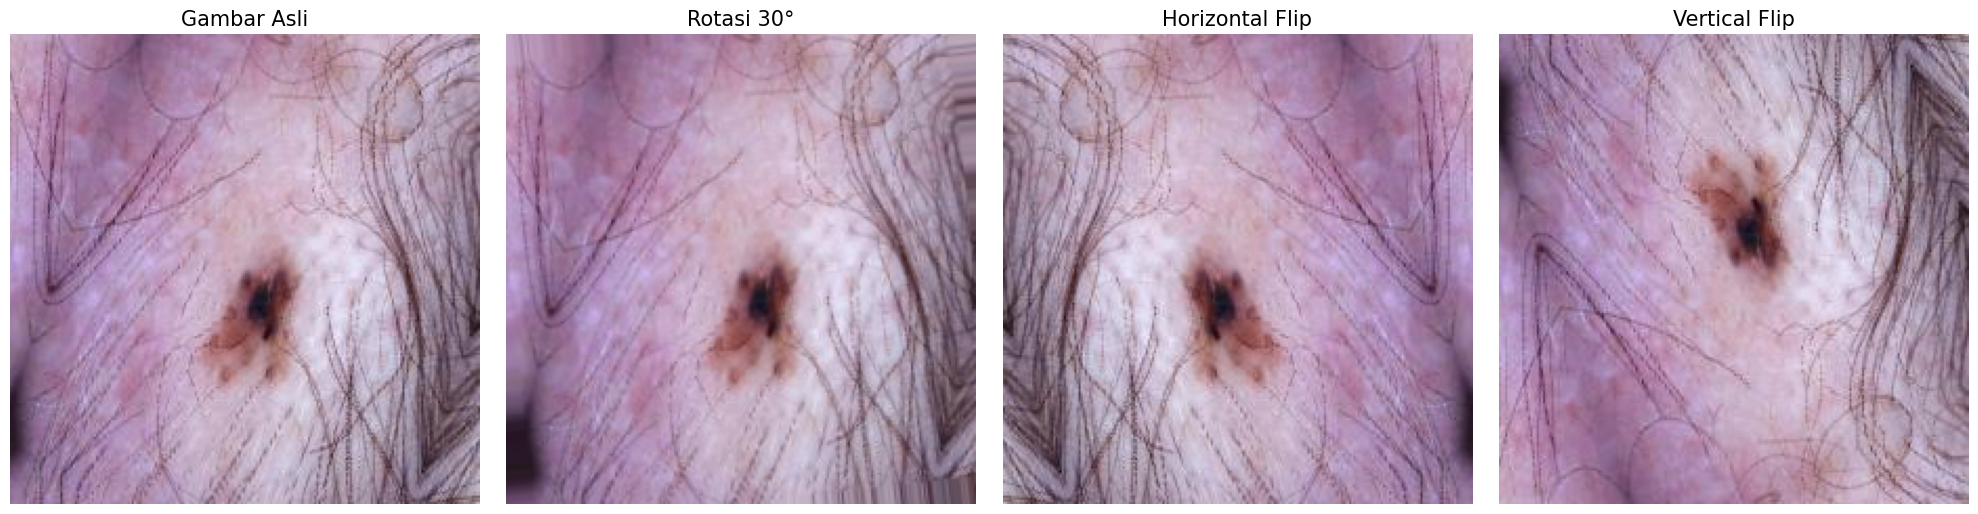

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

def apply_augmentations(image_path, img_size=(224, 224)):
    # Load and prepare the image
    original = load_img(image_path, target_size=img_size)
    original_array = img_to_array(original)
    
    # Create separate ImageDataGenerator instances for each transformation
    rotation_datagen = ImageDataGenerator(rotation_range=30)
    h_flip_datagen = ImageDataGenerator(horizontal_flip=True)
    v_flip_datagen = ImageDataGenerator(vertical_flip=True)
    
    # Prepare image for augmentation (add batch dimension)
    img_batch = np.expand_dims(original_array, 0)
    
    # Apply specific augmentations
    rotation_iter = rotation_datagen.flow(img_batch, batch_size=1)
    h_flip_iter = h_flip_datagen.flow(img_batch, batch_size=1)
    v_flip_iter = v_flip_datagen.flow(img_batch, batch_size=1)
    
    # Get augmented images
    rotated_img = next(rotation_iter)[0].astype('uint8')
    h_flipped_img = next(h_flip_iter)[0].astype('uint8')
    v_flipped_img = next(v_flip_iter)[0].astype('uint8')
    
    return original_array.astype('uint8'), rotated_img, h_flipped_img, v_flipped_img

def plot_augmented_images(original, rotated, h_flip, v_flip):
    plt.figure(figsize=(20, 5))
    
    images = [original, rotated, h_flip, v_flip]
    titles = ["Gambar Asli", "Rotasi 30°", "Horizontal Flip", "Vertical Flip"]
    
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i])
        plt.title(titles[i], fontsize=15)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Path gambar
image_path = '/workspace/dermmel/DermMel/train_sep/Melanoma/AUG_0_1780.jpeg'

# Terapkan augmentasi dan tampilkan hasilnya
original, rotated, h_flip, v_flip = apply_augmentations(image_path)
plot_augmented_images(original, rotated, h_flip, v_flip)

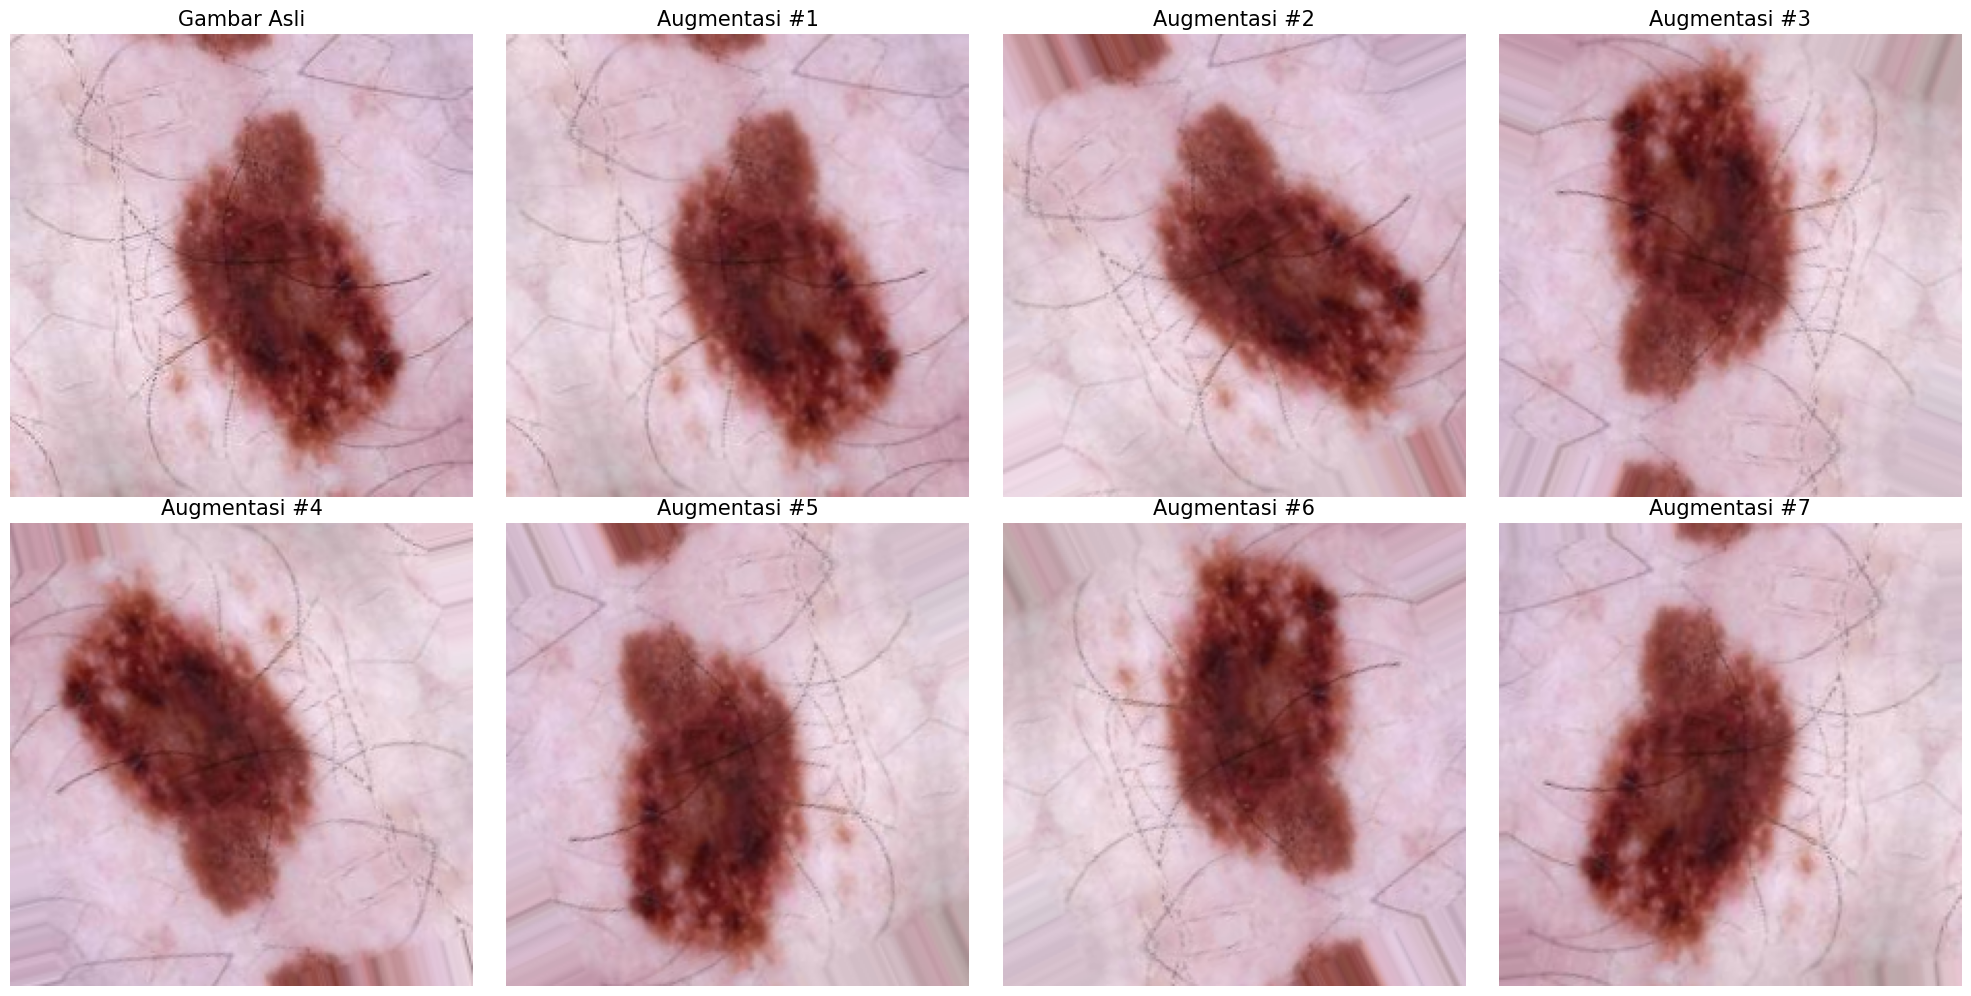

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

# Buat ImageDataGenerator dengan semua transformasi
datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load gambar
image_path = '/workspace/dermmel/DermMel/train_sep/Melanoma/AUG_0_2471.jpeg'
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)

# Generate beberapa contoh hasil augmentasi
plt.figure(figsize=(20, 10))

# Tampilkan gambar asli
plt.subplot(2, 4, 1)
plt.imshow(image_array[0].astype('uint8'))
plt.title('Gambar Asli', fontsize=15)
plt.axis('off')

# Generate dan tampilkan 7 hasil augmentasi
aug_iterator = datagen.flow(image_array, batch_size=1)
for i in range(7):
    aug_img = next(aug_iterator)[0].astype('uint8')
    plt.subplot(2, 4, i+2)
    plt.imshow(aug_img)
    plt.title(f'Augmentasi #{i+1}', fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()